# Neural functional theory for inhomogeneous fluids &ndash; Tutorial

This material provides a pedagogical introduction to the concepts and methods presented in

**Neural functional theory of inhomogeneous fluids: Fundamentals and applications**  
Florian Sammüller, Sophie Hermann, Daniel de las Heras, and Matthias Schmidt (2023); [arxiv:2307.04539](https://arxiv.org/abs/2307.04539).

We show how the physics of simple fluids can be described via **many-body simulations** and **classical density functional theory** (DFT) and how the two approaches can be combined with the help of machine learning techniques to a **neural functional theory**.
Compared to the above publication, we take a step back and consider here a one-dimensional system of hard rods.
We demonstrate for this simple model fluid the central methods of the different approaches and provide hands-on code examples and exercises in the programming language Julia.
Besides the theoretical overview given here, a more in-depth account of the physical and methodological background can be found in the accompanying manuscript:

**Why neural functionals suit statistical mechanics**  
Florian Sammüller, Sophie Hermann, and Matthias Schmidt (2023).

## Part 1: Many-body simulations

Many-body simulations have long become a standard tool for the investigation of classical fluids.
Conceptually, they offer a rather straightforward way to predict the behavior of a fluid from a microscopic description, i.e. by specifying the interactions of its constituent particles.
However, simulations often come with a significant demand of computational resources.

In the following, we focus on Monte Carlo methods for the description of equilibrium systems.
Specifically, we choose the grand ensemble where the temperature $T$ and the chemical potential $\mu$ are kept fixed (we also specify the length $L$ of the one-dimensional domain).
The statistical mechanics of such a system is then determined by the equilibrium distribution function $\psi(x^{(N)}) \sim \exp(-\beta (U(x^{(N)}) - \mu N)))$ where $\beta = 1 / (k_B T)$ with the Boltzmann constant $k_B$ and $U(x^{(N)}) = u(x^{(N)}) + \sum_{i=1}^N V_\mathrm{ext}(x_i)$ is the potential energy of a given microstate $x^{(N)} = (x_1, x_2, \dots, x_N)$.
The latter consists of a contribution due to an external potential $V_\mathrm{ext}(x)$, and of the internal energy $u(x^{(N)})$.
If the particles in the fluid possess pairwise interactions, $u(x^{(N)}) = \sum_{i=1}^N \sum_{j>i}^N \phi(|x_j - x_i|)$, where $\phi(d)$ is the interaction potential for a given distance $d$ of two particles.

In the grand canonical Monte Carlo (GCMC) method, microstates are generated according to their known equilibrium distribution.
This is done iteratively by mutating a given state $A$ into a new state $B$ with a probability such that a given distribution $P$ of states is kept intact.
The mutation happens in two stages: a trial transition selects a new state $B$, and a criterion $\mathrm{acc}(A \rightarrow B)$ determines if the new state $B$ shall be accepted or if the system shall be reset to the previous state $A$.
Specifically, a valid choice for this acceptance probability is the Metropolis criterion $\mathrm{acc}(A \rightarrow B) = \min(1, P(B) / P(A))$.

We now apply this scheme to the grand ensemble.
There are three possible trial transitions: i) a particle is moved to a new position, ii) a particle is inserted, iii) a particle is removed.
By identifying the goal distribution of states $P$ with the grand canonical equilibrium distribution $\psi$, one arrives straightforwardly at the acceptance criterion
$$
\mathrm{acc}(x^{(N)} \rightarrow \tilde{x}^{(N)}) = \min\left(1, \exp[-\beta(U(\tilde{x}^{(N)}) - U(x^{(N)}))]\right)
$$
for moving a particle and changing the initial microstate $x^{(N)}$ to the new configuration $\tilde{x}^{(N)}$.

Let us now illustrate this trial move with code.
For simplification, we provide some utilities for common tasks in simulation.jl, e.g. `calc_particle_interaction` for the calculation of the energy and `pbc!` for applying periodic boundary conditions.

In [1]:
include("simulation.jl");

Now we can write a function which performs trial moves and accepts them according to the above Metropolis criterion:

In [2]:
function trial_move(system; Δxmax=0.1)
    if isempty(system.particles)
        return
    end
    i = rand(1:length(system.particles))  # Select random particle i
    xbefore = system.particles[i]  # Save its initial position
    Ebefore = calc_particle_interaction(system, i)  # Calculate the initial potential energy of particle i
    system.particles[i] += Δxmax * (2 * rand() - 1)
    pbc!(system, i)  # Apply periodic boundary conditions (this places the particle back in the box if it has moved outside of the valid range)
    Eafter = calc_particle_interaction(system, i)  # Calculate the potential energy of particle i after it has been moved
    ΔE = Eafter - Ebefore
    if rand() > exp(-ΔE)
        system.particles[i] = xbefore  # Trial move rejected. Reset particle to previous state
    end
end

trial_move (generic function with 1 method)

As the particle number can fluctuate in the grand ensemble, there are additional transition which add and remove particles at random throughout the simulation.
The acceptance probabilities of these transitions can be derived by considering particle exchanges of the system with a virtual reservoir.
We spare this derivation here and only give the results
$$
\mathrm{acc}(x^{(N)} \rightarrow x^{(N+1)}) = \min\left(1, \frac{L}{N+1} \exp[\beta(\mu - U(x^{(N+1)}) + U(x^{(N)}))]\right),
$$
$$
\mathrm{acc}(x^{(N)} \rightarrow x^{(N+1)}) = \min\left(1, \frac{N}{L} \exp[-\beta(\mu + U(x^{(N-1)}) - U(x^{(N)}))]\right).
$$

These trial transitions are already implemented as `trial_insert` and `trial_delete` in simulation.jl.

Finally, we can write a simulation loop which consists of an equilibration stage and a stage in which measurements take place.
For each simulation step, we perform a sweep over a fixed number of trial transitions which are chosen at random.

In [3]:
function sweep(system::System; transitions=10, inout_probability=0.2)
    for _ in 1:transitions
        if rand() < inout_probability
            rand() < 0.5 ? trial_insert(system) : trial_delete(system)
        else
            trial_move(system)
        end
    end
end

function simulate(L::Number, μ::Number, Vext::Function, ϕ::Function; equilibrate_steps=100000, production_steps=1000000, sweep_transitions=10)
    system = System(L, μ, Vext, ϕ)
    histograms = Histograms(system)
    for _ in 1:equilibrate_steps
        sweep(system; transitions=sweep_transitions)
    end
    for _ in 1:production_steps
        sweep(system; transitions=sweep_transitions)
        sample(system, histograms)
    end
    get_results(system, histograms)
end

simulate (generic function with 1 method)

Equilibrium averages such as the one-body density profile $\rho(x) = \langle \sum_{i=1}^N \delta(x - x_i) \rangle$ are obtained by sampling.
For this, the particle configuration is recorded in a position-resolved histogram, which yields the desired average after normalization:

In [4]:
function sample(system::System, histograms::Histograms)
    for x in system.particles
        bin = ceil(Int, x / L * histograms.bins)
        histograms.ρ[bin] += 1
    end
    histograms.count += 1
end

sample (generic function with 1 method)

Let us now do some simulations of the hard rod fluid to illustrate the usage of the code.
We just pass the length $L$ of our system, the chemical potential $\mu$, the external potential $V_\mathrm{ext}(x)$ and the pair interaction potential $\phi(r)$ to the `simulate` function.
As a simple test case, we choose confinement between hard walls in which $V_\mathrm{ext} = \infty$.

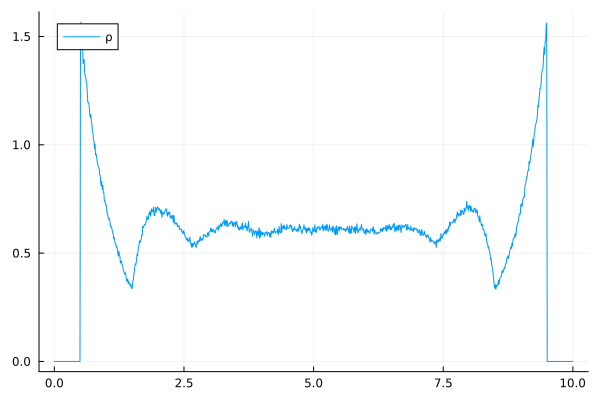

In [5]:
using Plots

L = 10.0
μ = 2.0
Vext(x) = x < 0.5 || x > L-0.5 ? Inf : 0  # Hard walls at the boundaries
ϕ(r) = r < 1.0 ? Inf : 0  # Hard core repulsion

# Depending on the number of steps, this might take a few seconds
result = simulate(L, μ, Vext, ϕ; equilibrate_steps=100000, production_steps=1000000, sweep_transitions=10)

plot(result[:x], result[:ρ], label="ρ")

## Part 2: Classical density functional theory

Classical DFT is founded on a minimization principle of the grand potential $\Omega[\rho]$, which can be expressed as a functional of the one-body density profile $\rho(x)$.
By carrying out the functional derivative $\delta \Omega[\rho] / \delta \rho(x)$ and demanding that it vanishes at the equilibrium density, one arrives at the Euler-Lagrange equation of DFT,
$$
c_1(x) = \ln\rho(x) + \beta (V_\mathrm{ext}(x) - \mu),
$$
where $c_1(x)$ is the one-body direct correlation function.
This rather abstract object attains a more fundamental meaning in classical DFT as it arises as a functional derivative, $c_1(x) = - \delta \beta F_\mathrm{exc}[\rho] / \delta \rho(x)$.
Here, $F_\mathrm{exc}[\rho]$ constitute the nontrivial part of $\Omega[\rho]$ which captures the effects of the internal interactions, and it is hence often called the "excess" (i.e. beyond ideal gas) part.
As an immediate consequence, $c_1(x; [\rho])$ is also a functional of the density, which is made explicit by the bracket notation.

By rearranging the above equation to
$$
\rho(x) = \exp(-\beta(V_\mathrm{ext}(x) - \mu) + c_1(x; [\rho])),
$$
we can reveal its use in actual DFT applications.
Given a suitable expression for $c_1(x; [\rho])$ (which one has to obtain somehow for a given type of model fluid), a self-consistent iteration scheme can be used to solve for $\rho(x)$.
One such method is the Picard iteration with mixing, in which the iteration is of the form
$$
\rho(x) \leftarrow (1 - \alpha) \rho(x) + \alpha \rho_\mathrm{EL}(x),
$$
where $\alpha$ is a mixing parameter and $\rho_\mathrm{EL}(x)$ is the right hand side of the rearranged Euler-Lagrange equation.

A simple but complete DFT program proceeds as follows:
The system parameters $T$ and $\mu$, an external potential $V_\mathrm{ext}(x)$ and a functional form of $c_1(x; [\rho])$ are given and a numerical (i.e. discretized) density profile is initialized, e.g. with a constant value.
Then the iteration is started and Picard steps are preformed which update $\rho(x)$ as illustrated above.
If the changes between iteration steps fall below a predefined tolerance, the iteration is stopped and the converged self-consistent densiy profile is obtained as a result.
We give an example of such a program in the following:

In [6]:
function minimize(L::Number, μ::Number, Vext::Function, get_c1::Function; α::Number=0.05, tol::Number=1e-8, maxiter::Int=10000)
    dx = 0.01
    xs = collect(dx/2:dx:L)  # Construct the numerical grid
    Vext = Vext.(xs)  # Evaluate the external potential on the grid
    infiniteVext = isinf.(Vext)  # Check where Vext is infinite to set ρ to 0 there
    ρ, ρEL = zero(xs), zero(xs)  # Preallocate the density profiles for iteration
    fill!(ρ, 0.5)  # Start with a bulk density of 0.5
    c1 = get_c1(xs)  # Obtain the c1 functional as given by a suitable approximation
    i = 0
    while true
        ρEL .= exp.(μ .- Vext .+ c1(ρ))  # Evaluate the RHS of the Euler-Lagrange equation
        ρ .= (1 - α) .* ρ .+ α .* ρEL  # Update ρ with a Picard iteration step
        ρ[infiniteVext] .= 0  # Set ρ to 0 where Vext = ∞
        clamp!(ρ, 0, Inf)  # Make sure that ρ does not become negative
        Δρmax = norm((ρ - ρEL)[.!infiniteVext], Inf)  # Calculate the remaining discrepancy to check convergence
        i += 1
        if Δρmax < tol
            break
        end
        if !isfinite(Δρmax) || i >= maxiter
            println("Did not converge (step: $(i), ‖Δρ‖: $(Δρmax))")
            return nothing
        end
    end
    Dict(:x => xs, :ρ => ρ)
end

minimize (generic function with 1 method)

The way in which $c_1(x; [\rho])$ appears seems innocuous at first.
However, the crux of DFT is finding a suitable functional expression for $c_1(x; [\rho])$ (or equivalently for $F_\mathrm{exc}[\rho]$) for a given fluid model, and much of the ongoing research deals with this problem.
In Part 3, we will show how to efficiently use neural networks to capture such a nontrivial functional mapping.

In the following, we proceed analytically as the focus lies on the hard rod system, which is the only system at present where the exact excess free energy functional could be found.
This success can be traced back to the purely geometrical nature of the problem.
A geometrical perspective to the construction of excess free energy functionals is also possible for the three-dimensional hard sphere system by using fundamental measure theory, although the result is no longer exact.


Returning to the exact hard rod result, the excess free energy can be expressed as 
$$
\beta F_\mathrm{exc} = \int \mathrm{d}x \Phi(n_0(x), n_1(x))
$$
where the free energy density has the form $\Phi(n_0(x), n_1(x)) = - n_0(x) \ln(1 - n_1(x))$.
The functions $n_0(x)$ and $n_1(x)$ are *weighted* densities which arise via convolutions with the weight functions $\omega_0(x) = (\delta(x-R) + \delta(x+R)) / 2$ and $\omega_1(x) = \Theta(R - |x|)$, i.e. $n_\alpha(x) = (\omega_\alpha \star \rho)(x)$.
From this excess free energy functional, one can easily obtain
$$
c_1(x; [\rho]) = - \sum_{\alpha=0,1} \left(\omega_\alpha \star \frac{\partial \Phi}{\partial n_\alpha}\right)(x)
$$
as the result for the one-body direct correlation function by functional differentiation.

We implement a function that constructs the Percus $c_1(x; [\rho])$ for the given numerical grid in the following.
As assistance, we provide the function `conv_fft` to evaluate convolutions efficiently in Fourier space and `get_weights_Percus` to obtain $\omega_\alpha(x)$ on the numerical grid in the file dft.jl.

In [7]:
include("dft.jl")

function get_c1_Percus(xs)
    ω0, ω1 = get_weights_Percus(xs)
    n0, n1 = zero(xs), zero(xs)
    ϕ0, ϕ1 = zero(xs), zero(xs)
    conv = (f, g) -> conv_fft(f, g, xs[2] - xs[1]; rfftP=plan_rfft(xs))
    c1 = zero(xs)
    function (ρ)
        c1 .= 0
        n0 .= conv(ρ, ω0)
        n1 .= conv(ρ, ω1)
        ϕ0 .= -log.(1 .- n1)
        ϕ1 .= n0 ./ (1 .- n1)
        c1 .-= conv(ϕ0, ω0)
        c1 .-= conv(ϕ1, ω1)
        c1
    end
end

get_c1_Percus (generic function with 1 method)

Now we can perform some DFT minimizations to see if the results match the simulations.

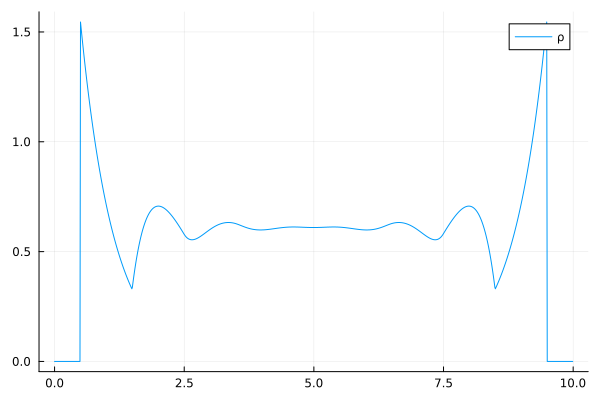

In [8]:
using Plots

L = 10.0
μ = 2.0
Vext(x) = x < 0.5 || x > L-0.5 ? Inf : 0
get_c1 = get_c1_Percus

result = minimize(L, μ, Vext, get_c1)

p = plot(result[:x], result[:ρ], label="ρ")
display(p)

As we can check by comparing simulation and DFT results for the same choices of $L$, $\mu$ and $V_\mathrm{ext}(x)$, the methods yield consistent density profiles.
However, it is obvious that both methods have substantial (and quite contrary) restrictions:
- The simulation data is noisy, which can only be improved with longer simulation runs. This quickly becomes prohibitively expensive, in particular if many individual simulations have to be performed for different system parameters. However, one is free to change the type of considered fluid by simply modifying the form of the internal interactions.
- The DFT calculation is fast and does not suffer from noisy results, thus enabling vast and efficient parameter studies. The results are exact for the case of hard rods, but as illustrated above, one had to find and implement a suitable density functional in order to capture the internal interactions. For more complex fluids, there is little hope in deriving an exact functional analytically.

In the final part of this tutorial, we will combine the advantages of both methods.
Using machine learning, we show that it is possible to acquire an accurate and flexible representation of $c_1(x; [\rho])$ by training a neural network with simulation data.
This results in a neural functional, which can be used in the minimization scheme as seen above, but which can also reveal more information about the statistical mechanics of the considered fluid.

## Part 3: Neural functional theory